In [41]:
import sys
print(sys.version)

3.11.5 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:26:23) [MSC v.1916 64 bit (AMD64)]


In [52]:
pip freeze


absl-py==2.1.0
aiobotocore @ file:///C:/b/abs_1c1a_vjay2/croot/aiobotocore_1682537737724/work
aiofiles @ file:///C:/b/abs_9ex6mi6b56/croot/aiofiles_1683773603390/work
aiohttp @ file:///C:/b/abs_b78zt6vo64/croot/aiohttp_1694181126607/work
aioitertools @ file:///tmp/build/80754af9/aioitertools_1607109665762/work
aiosignal @ file:///tmp/build/80754af9/aiosignal_1637843061372/work
aiosqlite @ file:///C:/b/abs_9djc_0pyi3/croot/aiosqlite_1683773915844/work
alabaster @ file:///home/ktietz/src/ci/alabaster_1611921544520/work
anaconda-anon-usage @ file:///C:/b/abs_f4tsjyl9va/croot/anaconda-anon-usage_1695310457827/work
anaconda-catalogs @ file:///C:/b/abs_8btyy0o8s8/croot/anaconda-catalogs_1685727315626/work
anaconda-client @ file:///C:/b/abs_80wttmgui4/croot/anaconda-client_1694625288614/work
anaconda-cloud-auth @ file:///C:/b/abs_5cjpnu6wjb/croot/anaconda-cloud-auth_1694462130037/work
anaconda-navigator @ file:///C:/b/abs_ab00e0_u7e/croot/anaconda-navigator_1695238210954/work
anaconda-project

In [54]:
pip show itertools

Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from itertools import product


In [2]:
all_weekly = pd.read_csv('./all_orders_weekly.csv', sep=';', index_col='date', parse_dates=True, dayfirst=True)
all_monthly = pd.read_csv('./all_orders_monthly.csv', sep=';', index_col='date', parse_dates=True, dayfirst=True)

In [3]:
all_monthly.index.freq = 'MS'
all_weekly.index.freq = 'W-SAT'

In [4]:
#definicao de periodos para teste
test_periods = 3
chart_train_period = 12 - test_periods

In [5]:
data = all_monthly

In [6]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Sales,43.0,901.883721,391.931858,252.0,638.5,861.0,1227.0,1841.0


# Funções

In [7]:
def vendas(df, y, title, xlabel, ylabel):
    ax = df.plot.line(y=y, figsize = (12,5), label = ylabel)
    ax.set_ylim(bottom=0)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    return plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

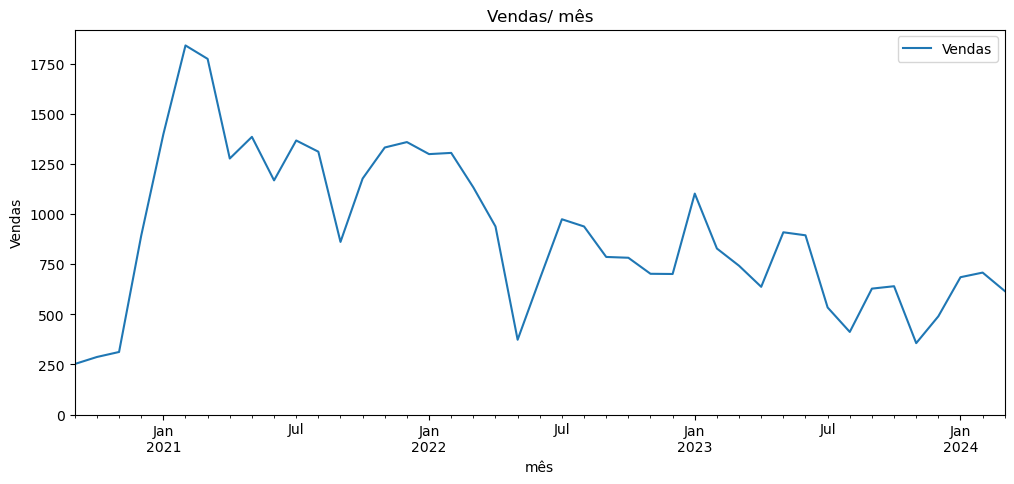

In [8]:
vendas(data, 'Sales', 'Vendas/ mês', 'mês', 'Vendas')

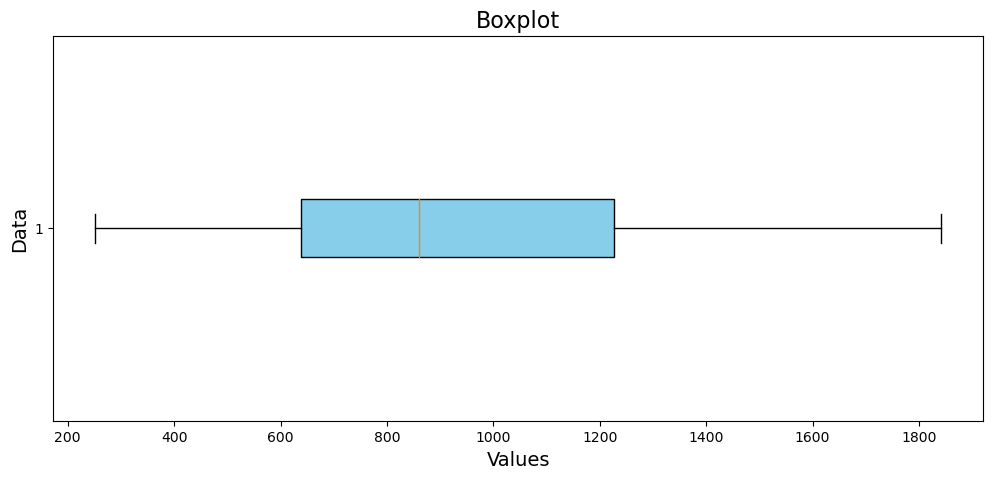

In [9]:
# Creating a larger figure
plt.figure(figsize=(12, 5))

# Creating a horizontal box plot with custom colors
plt.boxplot(data, vert=False, patch_artist=True, boxprops=dict(facecolor="skyblue"))

# Adding labels
plt.title('Boxplot', fontsize=16)
plt.xlabel('Values', fontsize=14)
plt.ylabel('Data', fontsize=14)

# Displaying the plot
plt.show()

Indices of outliers: []


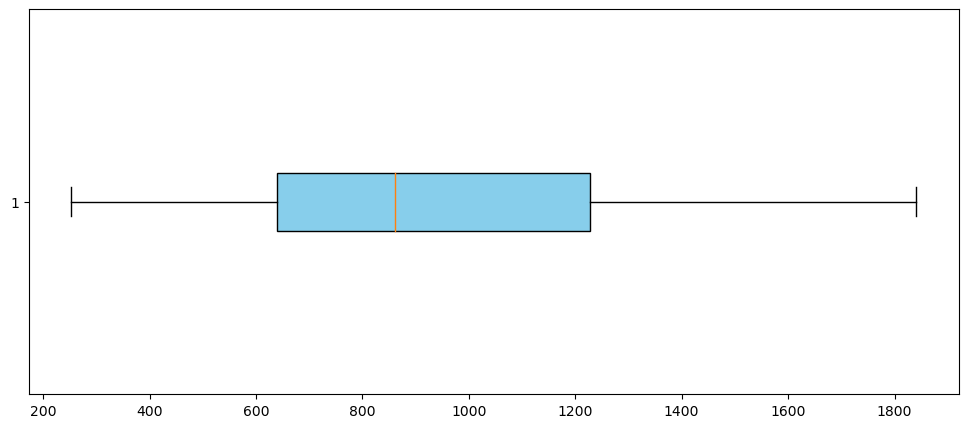

<Figure size 1200x500 with 0 Axes>

In [10]:



# Creating a box plot
plt.figure(figsize=(12, 5))
plt.boxplot(data, vert=False, patch_artist=True, boxprops=dict(facecolor="skyblue"))
plt.figure(figsize=(12, 5))

# Calculating the quartiles and IQR
q1 = np.percentile(data, 25)
q3 = np.percentile(data, 75)
iqr = q3 - q1

# Determining the outlier threshold
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Finding indices of outliers
outlier_indices = np.where((np.array(data) < lower_bound) | (np.array(data) > upper_bound))[0]

print("Indices of outliers:", outlier_indices)

In [11]:
def interpolate_outliers(data, outlier_indexes):
    interpolated_data = data.copy()  # Create a copy of the original data to avoid modification
    
    for idx in outlier_indexes:
        if idx == 0 or idx == len(data) - 1:  # Skip if outlier is at the boundary
            continue
        
        # Linear interpolation
        interpolated_data[idx] = (data[idx - 1] + data[idx + 1]) / 2.0
    
    return interpolated_data

In [12]:
data['Sales'] = interpolate_outliers(data['Sales'], outlier_indices)

In [13]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Sales,43.0,901.883721,391.931858,252.0,638.5,861.0,1227.0,1841.0


## Erro, Tendência e Sazonalidade

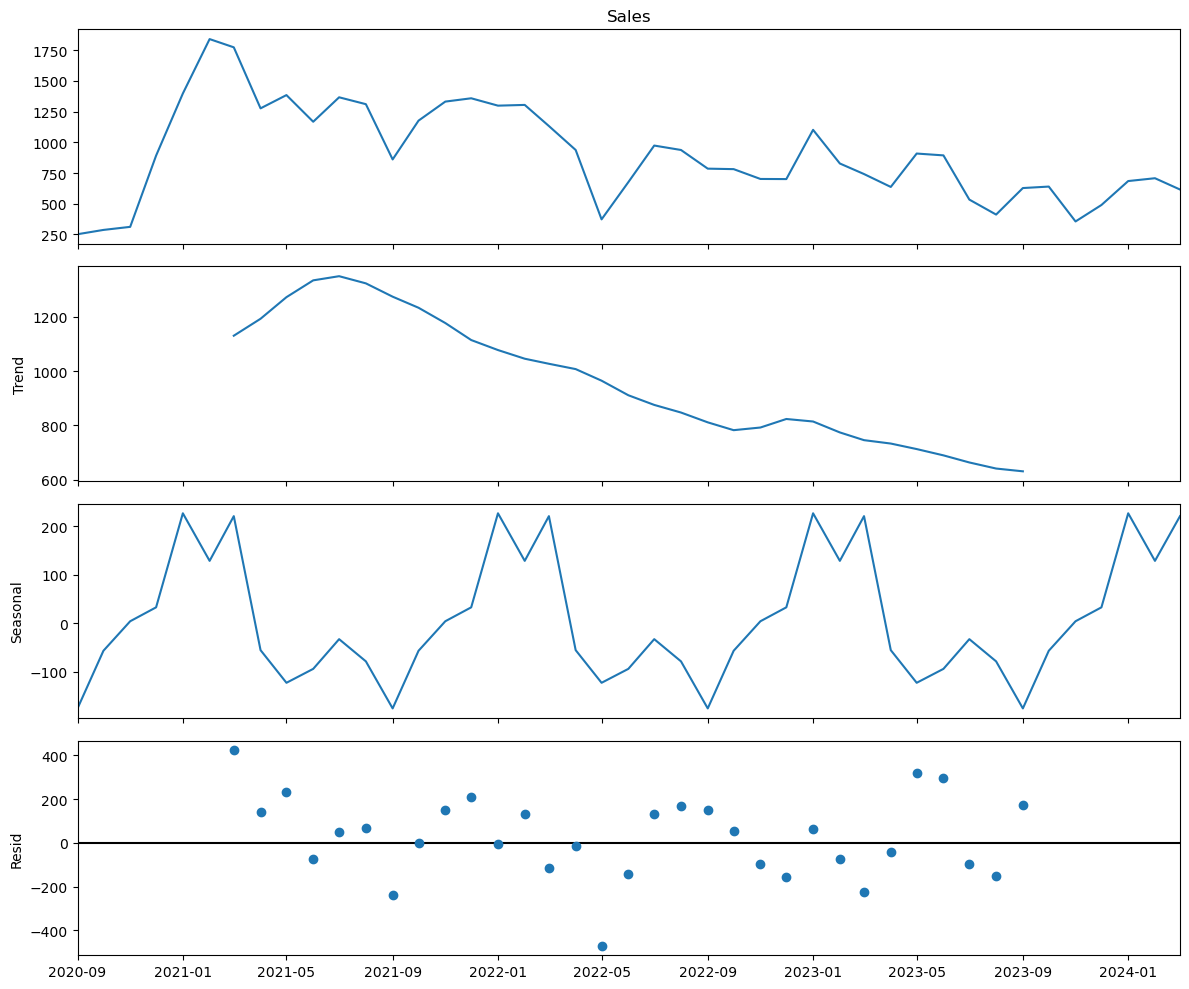

In [14]:
from pylab import rcParams
rcParams['figure.figsize'] = 12,10

seasonalDecompose = seasonal_decompose(data['Sales'])
seasonalDecompose.plot();

In [15]:
train = data[:- test_periods]
test = data[-test_periods:]

In [16]:
result= []

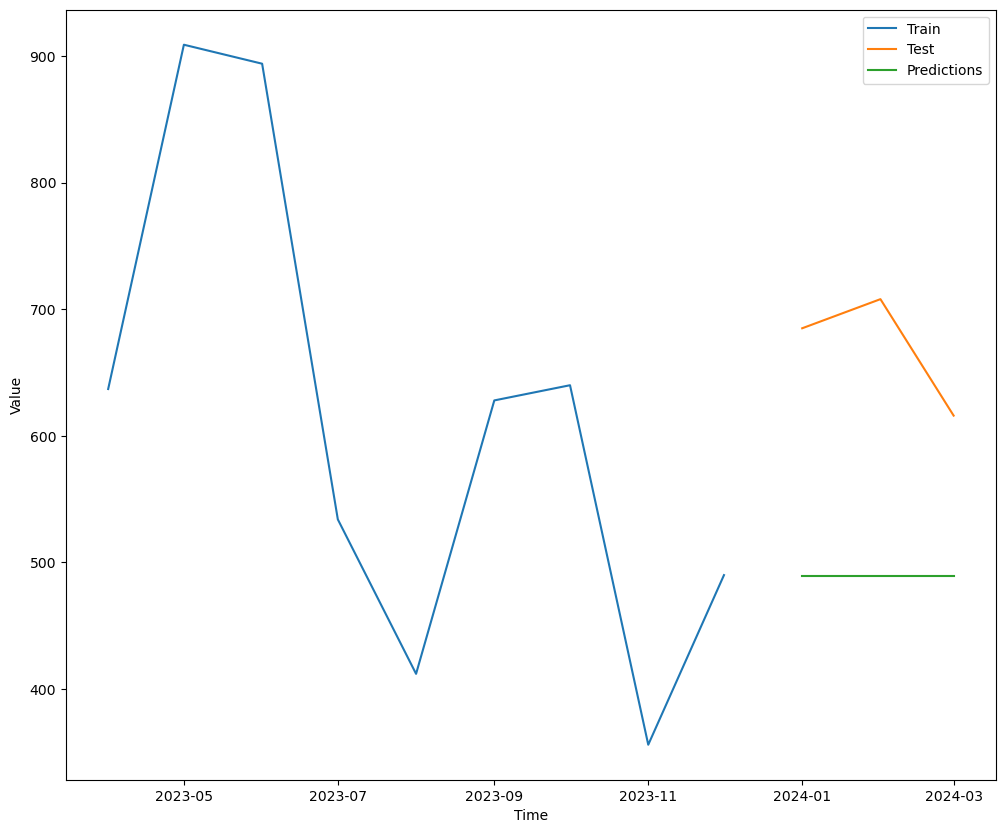

Mean Squared Error: 34046.97542594815
Mean Absolute Error: 180.32956830127978
Mean Absolute Percentage Error: 0.2667022574285169
Root Mean Squared Error: 184.51822518642473
Total Integrated Error: 0.2750691330534955
Autocorrelation of Errors (lag 1): -0.32051282051282065
                       SimpleExpSmoothing Model Results                       
Dep. Variable:                  Sales   No. Observations:                   40
Model:             SimpleExpSmoothing   SSE                        2693686.329
Optimized:                       True   AIC                            448.702
Trend:                           None   BIC                            452.079
Seasonal:                        None   AICC                           449.845
Seasonal Periods:                None   Date:                 Mon, 01 Apr 2024
Box-Cox:                        False   Time:                         17:39:59
Box-Cox Coeff.:                  None                                         
                 

In [17]:
# Create SES model
model = SimpleExpSmoothing(train)

# Fit the model
model_fit = model.fit()

# Make predictions
predictions = model_fit.forecast(steps=test_periods)

# Plot train, test, and predictions
plt.plot(train[-chart_train_period:], label='Train')
plt.plot(test, label='Test')
plt.plot(predictions, label='Predictions')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

# Calculate errors
mse = mean_squared_error(test, predictions)
mae = mean_absolute_error(test, predictions)
mape = mean_absolute_percentage_error(test, predictions)
rmse = np.sqrt(mse)
tic = np.sqrt(np.sum((test['Sales'] - predictions)**2) / np.sum(test['Sales']**2))
acf1 = acf(np.array(test['Sales'] - predictions).flatten(), fft=False)[1]

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("Mean Absolute Percentage Error:", mape)
print("Root Mean Squared Error:", rmse)
print("Total Integrated Error:", tic)
print("Autocorrelation of Errors (lag 1):", acf1)

print(model_fit.summary())

card = {'model': 'SES',
       "Mean Squared Error" : mse,
       "Mean Absolute Error" : mae,
       "Mean Absolute Percentage Error" : mape,
        "Root Mean Squared Error" : rmse,
       "Total Integrated Error" : tic,
       "Autocorrelation of Errors (lag 1)" : acf1}

result.append(card)

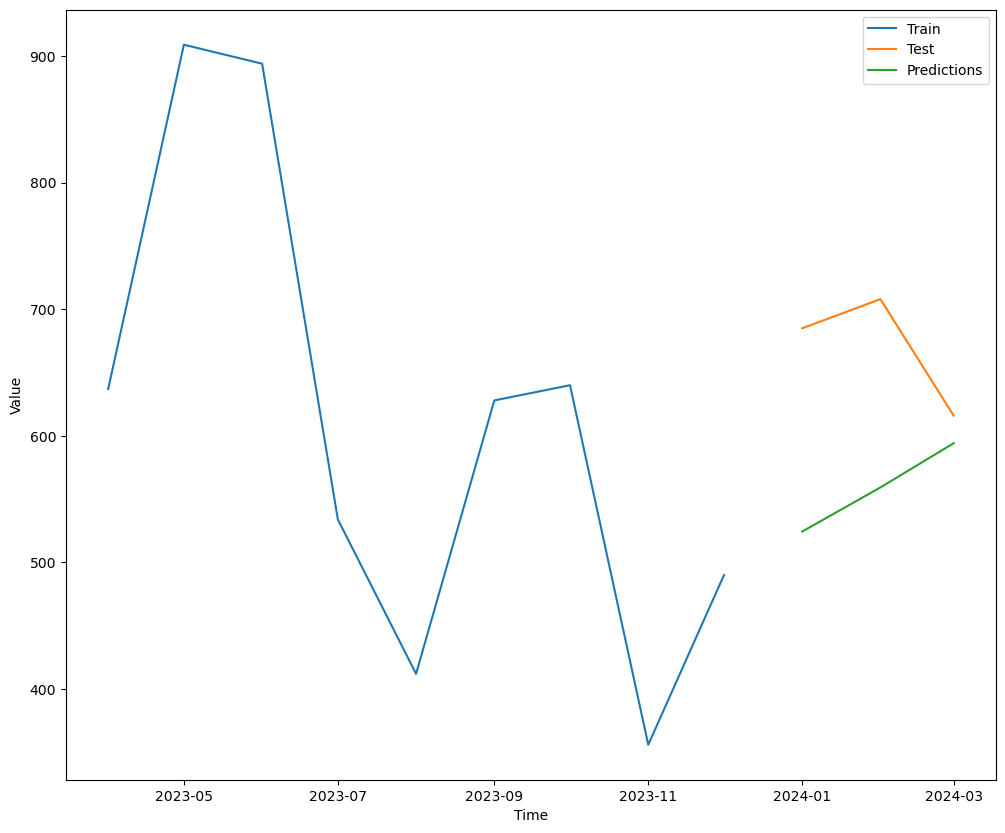

Mean Squared Error: 16129.372207353392
Mean Absolute Error: 110.38680128232791
Mean Absolute Percentage Error: 0.15998786257969475
Root Mean Squared Error: 127.00146537482703
Total Integrated Error: 0.1893264632362579
Autocorrelation of Errors (lag 1): -0.12418842002391817
                              Holt Model Results                              
Dep. Variable:                  Sales   No. Observations:                   40
Model:                           Holt   SSE                        2726523.017
Optimized:                       True   AIC                            453.186
Trend:                       Additive   BIC                            459.942
Seasonal:                        None   AICC                           455.732
Seasonal Periods:                None   Date:                 Mon, 01 Apr 2024
Box-Cox:                        False   Time:                         17:40:16
Box-Cox Coeff.:                  None                                         
               

In [18]:
model = Holt(train)

# Fit the model
model_fit = model.fit()

# Make predictions
predictions = model_fit.forecast(steps=test_periods)

# Plot train, test, and predictions
plt.plot(train[-chart_train_period:], label='Train')
plt.plot(test, label='Test')
plt.plot(predictions, label='Predictions')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

# Calculate errors
mse = mean_squared_error(test, predictions)
mae = mean_absolute_error(test, predictions)
mape = mean_absolute_percentage_error(test, predictions)
rmse = np.sqrt(mse)
tic = np.sqrt(np.sum((test['Sales'] - predictions)**2) / np.sum(test['Sales']**2))
acf1 = acf(np.array(test['Sales'] - predictions).flatten(), fft=False)[1]

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("Mean Absolute Percentage Error:", mape)
print("Root Mean Squared Error:", rmse)
print("Total Integrated Error:", tic)
print("Autocorrelation of Errors (lag 1):", acf1)

print(model_fit.summary())

card = {'model': 'HOLT',
       "Mean Squared Error" : mse,
       "Mean Absolute Error" : mae,
       "Mean Absolute Percentage Error" : mape,
        "Root Mean Squared Error" : rmse,
       "Total Integrated Error" : tic,
       "Autocorrelation of Errors (lag 1)" : acf1}

result.append(card)

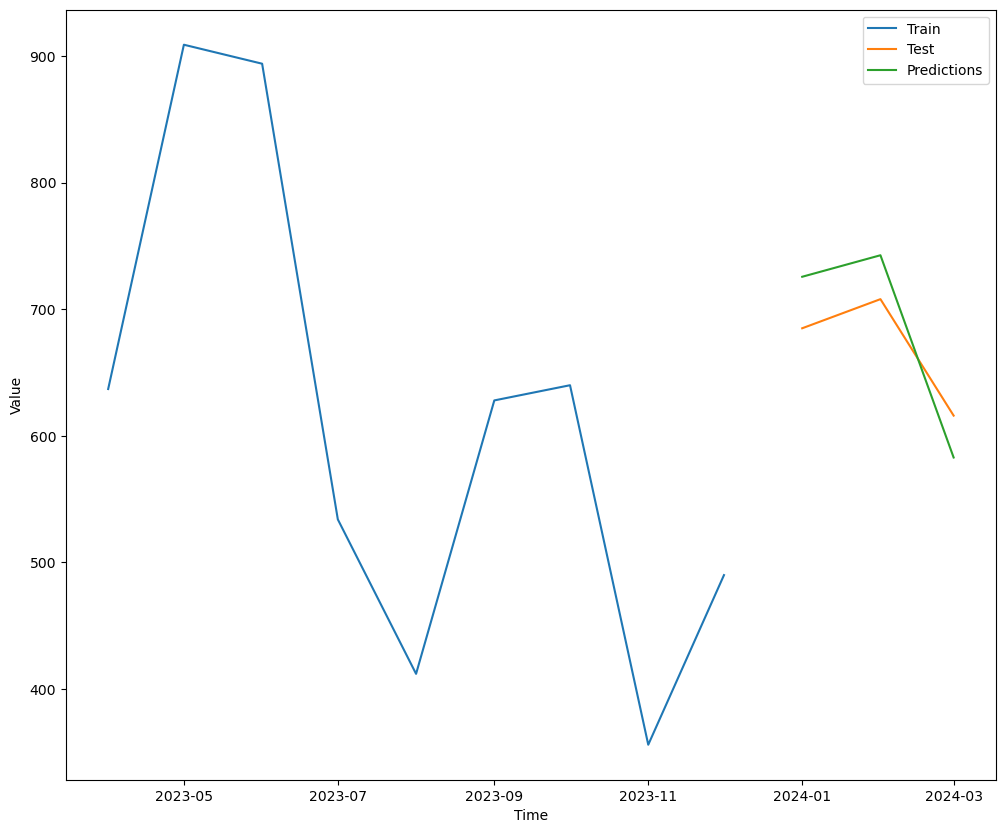

Mean Squared Error: 1317.66707140447
Mean Absolute Error: 36.15181297298121
Mean Absolute Percentage Error: 0.054031387529223505
Root Mean Squared Error: 36.299684177751054
Total Integrated Error: 0.05411347657827068
Autocorrelation of Errors (lag 1): -0.12626829199218836
                       ExponentialSmoothing Model Results                       
Dep. Variable:                    Sales   No. Observations:                   40
Model:             ExponentialSmoothing   SSE                        2394753.034
Optimized:                         True   AIC                            471.996
Trend:                         Additive   BIC                            499.019
Seasonal:                      Additive   AICC                           504.568
Seasonal Periods:                    12   Date:                 Mon, 01 Apr 2024
Box-Cox:                          False   Time:                         17:40:29
Box-Cox Coeff.:                    None                                        

In [19]:
# Create Holt-Winters additive model
model = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=12)

# Fit the model
model_fit = model.fit()

# Make predictions
predictions = model_fit.forecast(steps=test_periods)

# Plot train, test, and predictions
plt.plot(train[-chart_train_period:], label='Train')
plt.plot(test, label='Test')
plt.plot(predictions, label='Predictions')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

# Calculate errors
mse = mean_squared_error(test, predictions)
mae = mean_absolute_error(test, predictions)
mape = mean_absolute_percentage_error(test, predictions)
rmse = np.sqrt(mse)
tic = np.sqrt(np.sum((test['Sales'] - predictions)**2) / np.sum(test['Sales']**2))
acf1 = acf(np.array(test['Sales'] - predictions).flatten(), fft=False)[1]

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("Mean Absolute Percentage Error:", mape)
print("Root Mean Squared Error:", rmse)
print("Total Integrated Error:", tic)
print("Autocorrelation of Errors (lag 1):", acf1)

print(model_fit.summary())

card = {'model': 'HW-Add',
       "Mean Squared Error" : mse,
       "Mean Absolute Error" : mae,
       "Mean Absolute Percentage Error" : mape,
        "Root Mean Squared Error" : rmse,
       "Total Integrated Error" : tic,
       "Autocorrelation of Errors (lag 1)" : acf1}

result.append(card)

C:\Users\vgarc\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


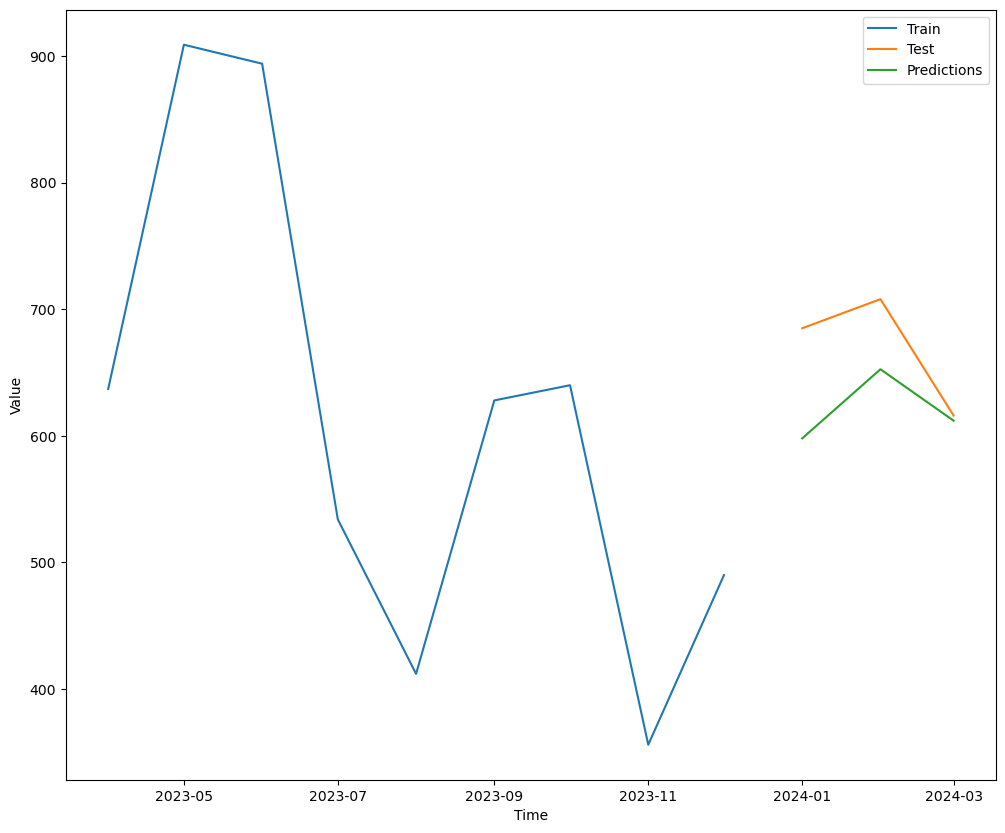

Mean Squared Error: 3550.0653702457607
Mean Absolute Error: 48.80177525276338
Mean Absolute Percentage Error: 0.07058804263610599
Root Mean Squared Error: 59.58242501145586
Total Integrated Error: 0.0888220444163033
Autocorrelation of Errors (lag 1): -0.012346658674656192
                       ExponentialSmoothing Model Results                       
Dep. Variable:                    Sales   No. Observations:                   40
Model:             ExponentialSmoothing   SSE                        2738547.040
Optimized:                         True   AIC                            477.362
Trend:                   Multiplicative   BIC                            504.384
Seasonal:                Multiplicative   AICC                           509.934
Seasonal Periods:                    12   Date:                 Mon, 01 Apr 2024
Box-Cox:                          False   Time:                         17:40:42
Box-Cox Coeff.:                    None                                        

In [20]:
# Create Holt-Winters additive model
model = ExponentialSmoothing(train, trend='mul', seasonal='mul', seasonal_periods=12)

# Fit the model
model_fit = model.fit()

# Make predictions
predictions = model_fit.forecast(steps=test_periods)

# Plot train, test, and predictions
plt.plot(train[-chart_train_period:], label='Train')
plt.plot(test, label='Test')
plt.plot(predictions, label='Predictions')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

# Calculate errors
mse = mean_squared_error(test, predictions)
mae = mean_absolute_error(test, predictions)
mape = mean_absolute_percentage_error(test, predictions)
rmse = np.sqrt(mse)
tic = np.sqrt(np.sum((test['Sales'] - predictions)**2) / np.sum(test['Sales']**2))
acf1 = acf(np.array(test['Sales'] - predictions).flatten(), fft=False)[1]

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("Mean Absolute Percentage Error:", mape)
print("Root Mean Squared Error:", rmse)
print("Total Integrated Error:", tic)
print("Autocorrelation of Errors (lag 1):", acf1)

print(model_fit.summary())

card = {'model': 'HW-Mul',
       "Mean Squared Error" : mse,
       "Mean Absolute Error" : mae,
       "Mean Absolute Percentage Error" : mape,
        "Root Mean Squared Error" : rmse,
       "Total Integrated Error" : tic,
       "Autocorrelation of Errors (lag 1)" : acf1}

result.append(card)

In [38]:
# Define parameters to iterate over
error = ['add', 'mul']
trend = ['add', 'mul', None]
seasonality = ['add', 'mul', None]
damped = [False, True]

iter_results = []

best_model = None
best_criteria = float('inf')  # Initialize with a very large value

# Iterate over all combinations
for err, trnd, seas, dmpd in product(error, trend, seasonality, damped):
    try:
        # Fit ETS model
        ets_model = ETSModel(train['Sales'], trend=trnd, seasonal=seas, seasonal_periods=12, error=err, damped_trend=dmpd)
        ets_result = ets_model.fit()
        predictions = ets_result.forecast(steps=test_periods)
        mape = mean_absolute_percentage_error(test, predictions)
        
        iter_settings = {'err' : err, 
                         'trend' : trnd,
                         'seasonality' : seas,  
                         'Dumped Trend' : dmpd,
                         'MAPE' : mape}
        criterion = mape
        # Update best model if current model is better
        if criterion < best_criteria:
            best_criteria = criterion
            best_model = (err, trnd, seas, dmpd)
        iter_results.append(iter_settings)
    except:
        continue


print("Best ETS model:", best_model)
print("Best criterion:", best_criteria)

C:\Users\vgarc\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Best ETS model: ('add', 'add', 'mul', False)
Best criterion: 0.03319807065534733


In [39]:
pd.DataFrame(iter_results)

,err,trend,seasonality,Dumped Trend,MAPE
0,add,add,add,False,0.152450
1,add,add,add,True,0.157804
2,add,add,mul,False,0.033198
3,add,add,mul,True,0.123074
4,add,add,None,False,0.245811
5,add,add,None,True,0.264791
6,add,mul,add,False,0.098023
7,add,mul,add,True,0.169826
8,add,mul,mul,False,0.150712
9,add,mul,mul,True,0.276708


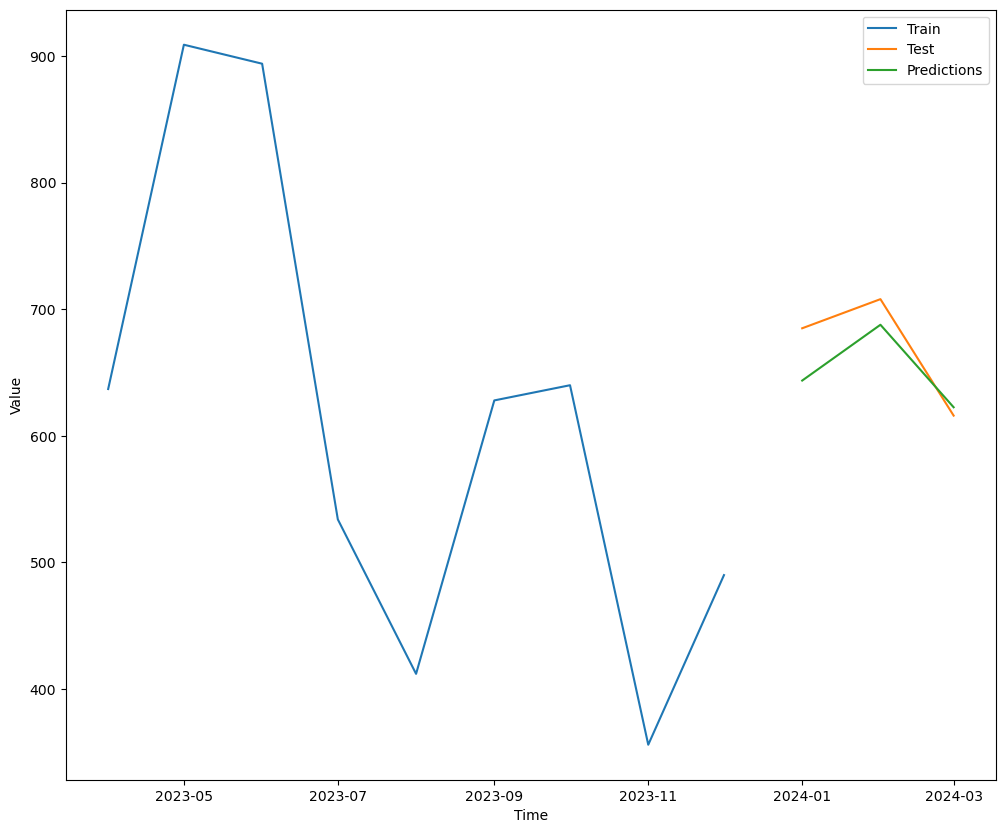

Mean Squared Error: 719.7899129215042
Mean Absolute Error: 22.713498166992736
Mean Absolute Percentage Error: 0.03319807065534733
Root Mean Squared Error: 26.828900702814945
Total Integrated Error: 0.03999497854288144
Autocorrelation of Errors (lag 1): -0.003196623383631663
                                 ETS Results                                  
Dep. Variable:                  Sales   No. Observations:                   40
Model:                       ETS(AAM)   Log Likelihood                -284.430
Date:                Mon, 01 Apr 2024   AIC                            604.859
Time:                        17:41:40   BIC                            635.259
Sample:                    09-01-2020   HQIC                           615.851
                         - 12-01-2023   Scale                        87869.402
Covariance Type:               approx                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
-----

In [22]:

model = ETSModel(train['Sales'], error=best_model[0], seasonal=best_model[2], trend=best_model[1], 
                 damped_trend=best_model[3], seasonal_periods=12)
# Fit the model
fit = model.fit(maxiter=10000)

# Make predictions
predictions = fit.forecast(steps=test_periods)

# Plot train, test, and predictions
plt.plot(train[-chart_train_period:], label='Train')
plt.plot(test, label='Test')
plt.plot(predictions, label='Predictions')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

# Calculate errors
mse = mean_squared_error(test, predictions)
mae = mean_absolute_error(test, predictions)
mape = mean_absolute_percentage_error(test, predictions)
rmse = np.sqrt(mse)
tic = np.sqrt(np.sum((test['Sales'] - predictions)**2) / np.sum(test['Sales']**2))
acf1 = acf(np.array(test['Sales'] - predictions).flatten(), fft=False)[1]

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("Mean Absolute Percentage Error:", mape)
print("Root Mean Squared Error:", rmse)
print("Total Integrated Error:", tic)
print("Autocorrelation of Errors (lag 1):", acf1)

print(fit.summary())


card = {'model': 'ETS',
       "Mean Squared Error" : mse,
       "Mean Absolute Error" : mae,
       "Mean Absolute Percentage Error" : mape,
        "Root Mean Squared Error" : rmse,
       "Total Integrated Error" : tic,
       "Autocorrelation of Errors (lag 1)" : acf1}

result.append(card)

In [23]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Assuming 'train' is your DataFrame containing the time series data
endog = fit.resid  # Extracting the endogenous variable

# Perform the Ljung-Box test
lags = 1  # Number of lags to consider
test_results = acorr_ljungbox(endog, lags=lags)


test_results


,lb_stat,lb_pvalue
1,12.810605,0.000345


# ARIMA

In [24]:
from statsmodels.tsa.stattools import adfuller

# Supondo que 'train' seja seu DataFrame contendo a série temporal
endog = train['Sales']  # Extrai a variável endógena

fuller = adfuller(endog, autolag='AIC')
print(f'ADF Statistic: {fuller[0]}')
print(f'n_lags: {fuller[1]}')
print(f'p-value: {fuller[1]}')
for key, value in fuller[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}') 

ADF Statistic: -2.6538159602378886
n_lags: 0.08237670272188768
p-value: 0.08237670272188768
Critial Values:
   1%, -3.6209175221605827
Critial Values:
   5%, -2.9435394610388332
Critial Values:
   10%, -2.6104002410518627


In [25]:
# Determine the number of differences needed
ndiffs = pm.arima.ndiffs(train['Sales'])

print("Number of differences needed:", ndiffs)

Number of differences needed: 0


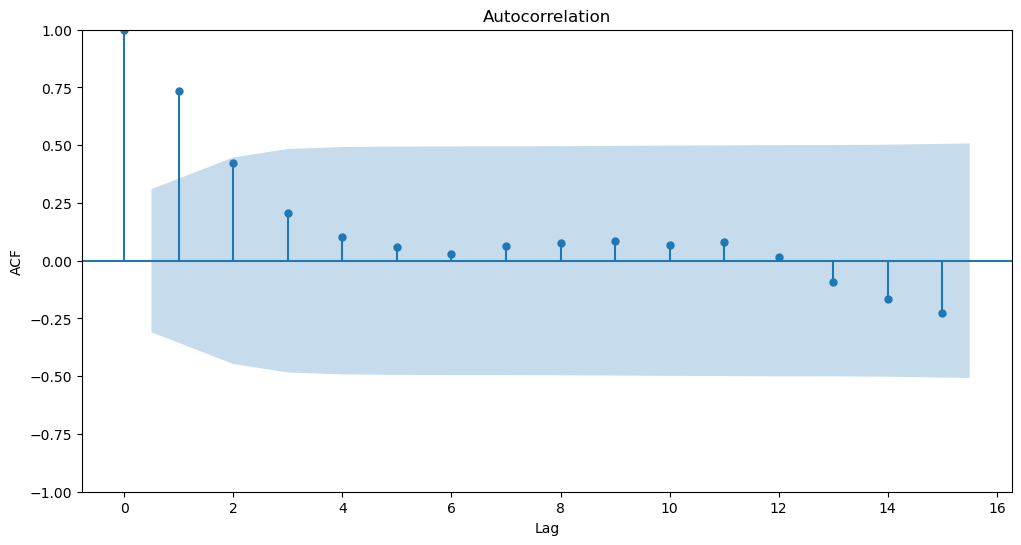

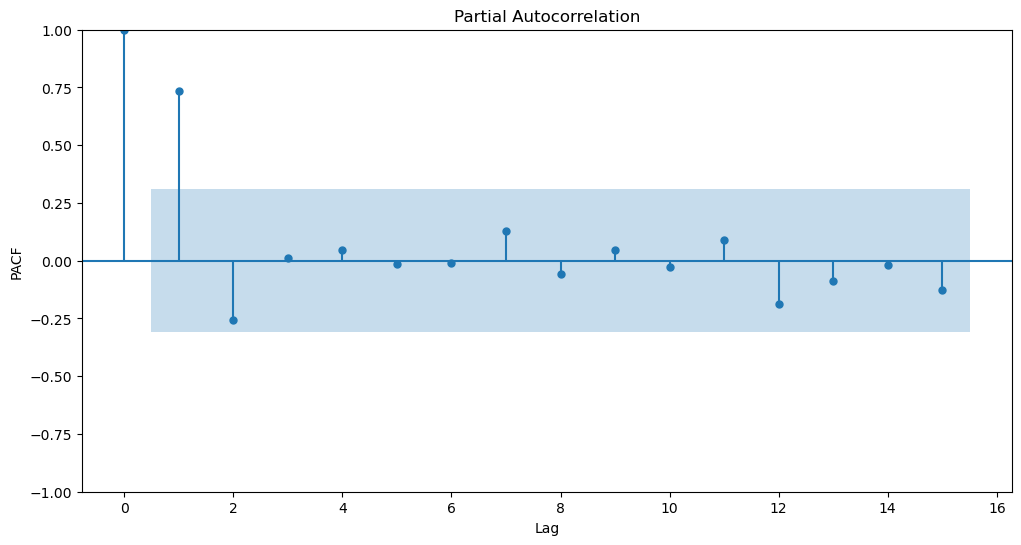

In [26]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf



# Plot autocorrelation
plt.figure(figsize=(12, 6))
plot_acf(train['Sales'], lags=15, ax=plt.gca())
plt.title('Autocorrelation')
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.show()

# Plot partial autocorrelation
plt.figure(figsize=(12, 6))
plot_pacf(train['Sales'], lags=15, ax=plt.gca())
plt.title('Partial Autocorrelation')
plt.xlabel('Lag')
plt.ylabel('PACF')
plt.show()

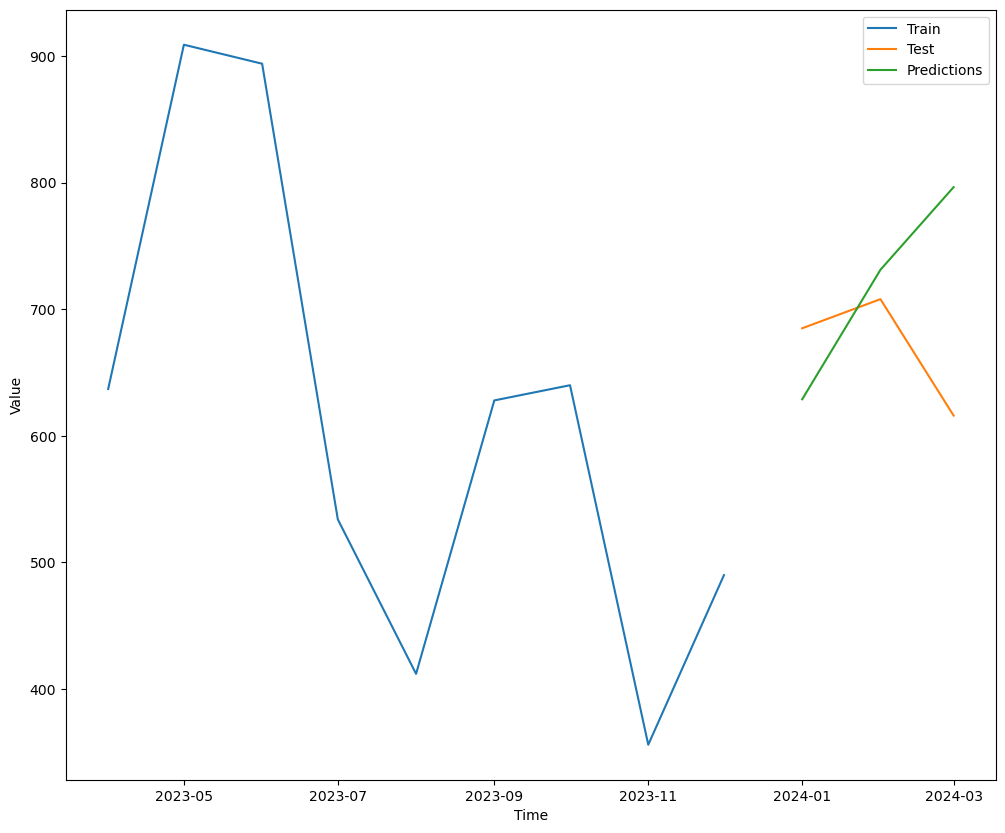

Mean Squared Error: 12089.691651784482
Mean Absolute Error: 86.60416726953015
Mean Absolute Percentage Error: 0.13590171882212612
Root Mean Squared Error: 109.95313388796374
Total Integrated Error: 0.16391179345303097
Autocorrelation of Errors (lag 1): -0.02330602785399651


In [33]:
# Fit auto ARIMA model
model = auto_arima(train['Sales'], 
                   start_p = 1, max_p = 10, 
                   start_q = 1, max_q = 10, 
                   seasonal = True, m =12, trace = False)

# Make predictions
predictions = model.predict(n_periods=test_periods)

# Plot train, test, and predictions
plt.plot(train[-chart_train_period:], label='Train')
plt.plot(test, label='Test')
plt.plot(predictions, label='Predictions')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

# Calculate errors
mse = mean_squared_error(test, predictions)
mae = mean_absolute_error(test, predictions)
mape = mean_absolute_percentage_error(test, predictions)
rmse = np.sqrt(mse)
tic = np.sqrt(np.sum((test['Sales'] - predictions)**2) / np.sum(test['Sales']**2))
acf1 = acf(np.array(test['Sales'] - predictions).flatten(), fft=False)[1]

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("Mean Absolute Percentage Error:", mape)
print("Root Mean Squared Error:", rmse)
print("Total Integrated Error:", tic)
print("Autocorrelation of Errors (lag 1):", acf1)

card = {'model': 'Arima',
       "Mean Squared Error" : mse,
       "Mean Absolute Error" : mae,
       "Mean Absolute Percentage Error" : mape,
        "Root Mean Squared Error" : rmse,
       "Total Integrated Error" : tic,
       "Autocorrelation of Errors (lag 1)" : acf1}

result.append(card)

In [29]:
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   40
Model:               SARIMAX(2, 0, 0)   Log Likelihood                -276.859
Date:                Mon, 01 Apr 2024   AIC                            561.718
Time:                        17:42:43   BIC                            568.474
Sample:                    09-01-2020   HQIC                           564.161
                         - 12-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    238.9055    102.865      2.323      0.020      37.293     440.518
ar.L1          0.9773      0.144      6.778      0.000       0.695       1.260
ar.L2         -0.2497      0.125     -1.996      0.0

In [30]:

endog = model.resid()  # Extracting the endogenous variable

# Perform the Ljung-Box test
lags = 1  # Number of lags to consider
test_results = acorr_ljungbox(endog, lags=lags)


test_results

,lb_stat,lb_pvalue
1,0.000384,0.984358


In [34]:
pd.DataFrame(result).T

,0,1,2,3,4,5
model,SES,HOLT,HW-Add,HW-Mul,ETS,Arima
Mean Squared Error,34046.975426,16129.372207,1317.667071,3550.06537,719.789913,12089.691652
Mean Absolute Error,180.329568,110.386801,36.151813,48.801775,22.713498,86.604167
Mean Absolute Percentage Error,0.266702,0.159988,0.054031,0.070588,0.033198,0.135902
Root Mean Squared Error,184.518225,127.001465,36.299684,59.582425,26.828901,109.953134
Total Integrated Error,0.275069,0.189326,0.054113,0.088822,0.039995,0.163912
Autocorrelation of Errors (lag 1),-0.320513,-0.124188,-0.126268,-0.012347,-0.003197,-0.023306
